# Photon ID Run 2 BDT classification

In [1]:
import uproot
import numpy as np
import pandas as pd
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

#import mplhep as hep
#hep.style.use("ATLAS")

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

import joblib

import seaborn as sns

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/"
savedir = "/home/chardong/y_identification/Venv/save_plots/Py8_yj_jj_train_skim30/evt_mu/"
#datadir = "/eos/user/m/mdelmast/Data/EGamma/PhotonID/Run2/"
savedirmodel = "/home/chardong/y_identification/Venv/BDT_model/"

In [3]:
#totald = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w.pkl")
#totald = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w_skim.pkl")
totald = pd.read_pickle(datadir+"RAW_data/Py8_yj_jj_mc16ade_pd122_train_w_skim_30.pkl")
totald.columns

Index(['y_Reta', 'y_Rphi', 'y_weta2', 'y_fracs1', 'y_weta1', 'y_wtots1',
       'y_Rhad', 'y_Rhad1', 'y_Eratio', 'y_deltae', 'y_convRadius',
       'y_convType', 'y_pt', 'y_eta', 'y_phi', 'evt_mu', 'y_IsTight',
       'y_IsLoose', 'y_truth_pt', 'y_truth_eta', 'weight', 'truth_label'],
      dtype='object')

In [4]:
totald['y_convType']

32567178    0
30571405    2
12717653    3
34705749    2
33543598    0
           ..
2043028     3
10418728    0
4572977     3
14851847    5
8883538     0
Name: y_convType, Length: 17471881, dtype: int32

In [5]:
shower_shape_var = ['y_Reta',
                    'y_Rphi',
                    'y_weta2',
                    'y_fracs1',
                    'y_weta1',
                    'y_wtots1',
                    'y_Rhad',
                    'y_Rhad1',
                    'y_Eratio', 
                    'y_deltae']

prcpl_vx = ['evt_mu']       #Principal vertex parametrs, feel free to rocket me if I'm wrong


conv_var = [ 'y_convRadius', 'y_convType']

kinem_var = ['y_pt', 'y_eta', 'y_phi']

#truth_var = ['y_truth_pt', 'y_truth_eta', 'y_truth_pdgId', 'y_truth_mother_pdgId' ]
truth_var = ['y_truth_pt', 'y_truth_eta' ]

discriminating_var = shower_shape_var + kinem_var + conv_var + prcpl_vx
discriminating_var

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType',
 'evt_mu']

### Prepare inputs for training

* `discriminating_var` containes the features used in the training
* Weights are added Y column to be able to access them after splitting in train and test samples.
* `test_size` represents the proportion of the dataset to include in the test split

In [6]:
set(totald.columns)-set(discriminating_var)

{'truth_label',
 'weight',
 'y_IsLoose',
 'y_IsTight',
 'y_truth_eta',
 'y_truth_pt'}

In [7]:
Y_var = ["truth_label",
         "weight",
         'y_IsTight',
         'y_IsLoose',
         'evt_mu', 
        ]

Y_var

['truth_label', 'weight', 'y_IsTight', 'y_IsLoose', 'evt_mu']

### Save X and Y datasets with relevant variables

* Adding truth variables to X for performance studies, will be removed after splitting

In [8]:
X = totald[discriminating_var+truth_var]
Y = totald[Y_var]

### Split dataset into train, validation and test samples

* Test dataset size: 20 %

In [9]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Split train + validation set into train and validation

* Train and validation are respectively 80% and 20% of 80% of total
* Save weights in separate arrays

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

In [11]:
weight_train = y_train["weight"]
weight_val   = y_val  ["weight"]
weight_test  = y_test ["weight"]

In [12]:
othervars_train = y_train[['evt_mu', 'y_IsLoose', 'y_IsTight']]
othervars_val   = y_val  [['evt_mu', 'y_IsLoose', 'y_IsTight']]
othervars_test  = y_test [['evt_mu', 'y_IsLoose', 'y_IsTight']]

In [13]:
truth_train = x_train[['y_truth_pt','y_truth_eta']]
truth_val   = x_val  [['y_truth_pt','y_truth_eta']]
truth_test  = x_test [['y_truth_pt','y_truth_eta']]

In [14]:
truth_var_drop = list(set(y_train.columns)-{'truth_label'})
truth_var_drop

['y_IsTight', 'evt_mu', 'y_IsLoose', 'weight']

In [15]:
y_train = y_train.drop(truth_var_drop, axis=1)
y_test  = y_test.drop(truth_var_drop, axis=1)
y_val   = y_val.drop(truth_var_drop, axis=1)

In [16]:
x_train = x_train.drop(truth_var, axis=1)
x_test  = x_test.drop(truth_var, axis=1)
x_val   = x_val.drop(truth_var, axis=1)

In [17]:
print('TRAINING   size = {:8d}'.format(len(y_train)))
print('TEST       size = {:8d}'.format(len(y_test)))
print('VALIDATION size = {:8d}'.format(len(y_val)))

TRAINING   size = 11182003
TEST       size =  3494377
VALIDATION size =  2795501


In [18]:
print('Number of signal events in test sample     :', len(y_test.query('truth_label == True')))
print('Number of background events in test sample :', len(y_test.query('truth_label == False')))

Number of signal events in test sample     : 2338410
Number of background events in test sample : 1155967


In [19]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

# BDT training

In [20]:
# Loading model from file
model_skim30_Addevtmu = joblib.load(savedirmodel+"skim30/LGBMClassifier_model_hard_no_loose_lr0.05_35_skim30_Addevtmu.pkl")

### Feature importance

Text(0.5, 1.0, 'Metric during training')

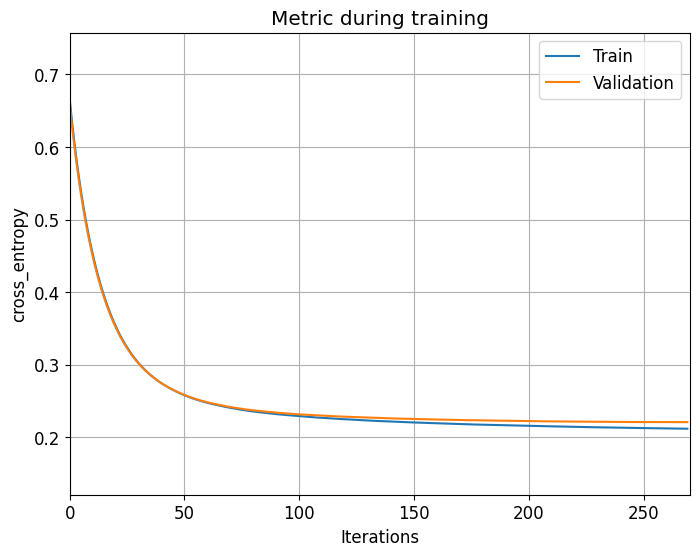

In [21]:
# Cross-entropy evolution during training
lgb.plot_metric(model_skim30_Addevtmu, figsize=(8,6))
plt.title('Metric during training')
#plt.savefig(savedir+'Addevtmu_metric_lr_0.09_35_skim30.pdf')

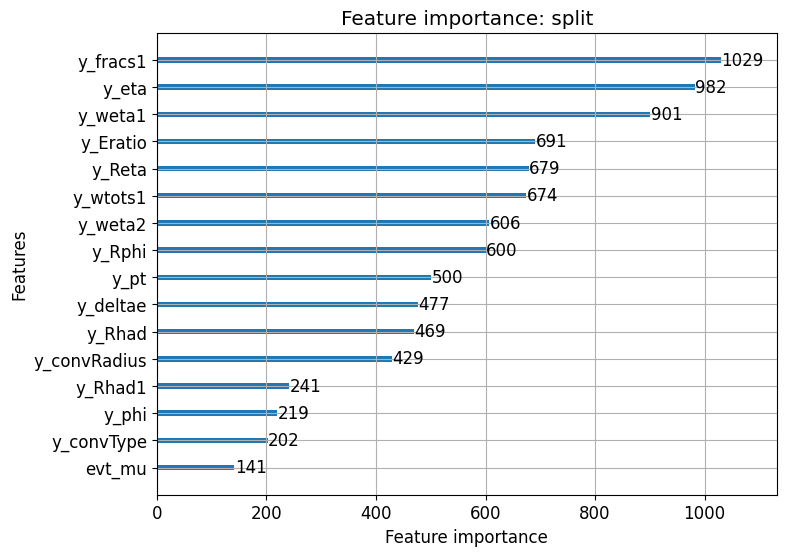

In [22]:
# Feature importance: Numbers of times the feature is used in a model
lgb.plot_importance(model_skim30_Addevtmu, importance_type='split', figsize=(8,6))
plt.title('Feature importance: split')
#plt.savefig(savedir+'AddEvtmu_feature_split_lr_0.09_35_skim30.pdf')
plt.show()

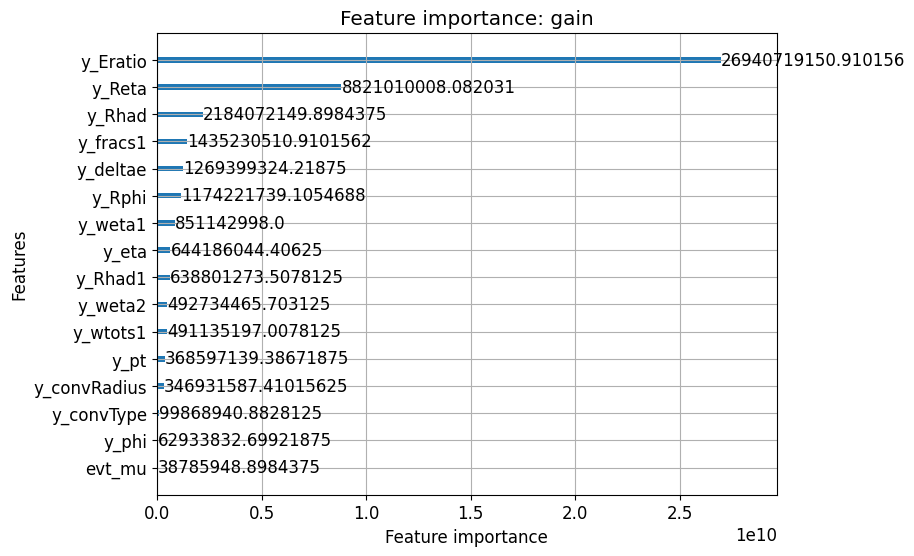

In [23]:
lgb.plot_importance(model_skim30_Addevtmu, importance_type='gain', precision = None, figsize=(8,6))
plt.title('Feature importance: gain')
#plt.savefig(savedir+'AddEvtmu_feature_gain_lr_0.09_35_skim30.pdf')
plt.show()

# Make predictions for test sample, add signal and background scores

In [24]:
y_pred_prob_test = model_skim30_Addevtmu.predict_proba(x_test)

df_pred_test = pd.DataFrame(y_pred_prob_test, columns=["background_score", "signal_score"])
df_pred_test.reset_index(inplace=True, drop=True)

In [25]:
y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True, drop=True)

truth_test.reset_index(inplace=True, drop=True)

othervars_test.reset_index(inplace=True, drop=True)

df_test_vars = x_test[kinem_var + conv_var]
df_test_vars.reset_index(inplace=True, drop=True)

weight_test = pd.DataFrame(weight_test)
weight_test.reset_index(inplace=True, drop=True)

In [26]:
df_test_Addevtmu = pd.concat([df_test_vars,
                     weight_test,
                     y_test,
                     othervars_test,
                     truth_test,
                     df_pred_test,
                    ], axis=1, join='inner', ignore_index=True)

In [27]:
col_names = list(df_test_vars.columns) + \
            list(weight_test.columns) + \
            list(y_test.columns) + \
            list(othervars_test.columns) + \
            list(truth_test.columns) + \
            list(df_pred_test.columns)
df_test_Addevtmu.columns = col_names

In [28]:
df_test_Addevtmu

y_pt     y_eta     y_phi  y_convRadius  y_convType      weight  \
0         51.956734  2.267797 -1.499033     49.392670           3   48.548934   
1         34.364429 -1.958636  1.959331    317.343506           1   38.855491   
2         39.007401  0.172711 -0.628337   9999.000000           0  554.386153   
3         86.679977  0.162386  2.113541   9999.000000           0   40.708948   
4        281.008636 -0.796674  0.281347   9999.000000           0    0.283104   
...             ...       ...       ...           ...         ...         ...   
3494372   43.406239  1.724553 -0.356645     88.554863           5   34.390531   
3494373  550.298889 -0.506703  1.353711   9999.000000           0    0.013548   
3494374  174.141190  0.462812  2.917594   9999.000000           0    2.829482   
3494375  280.226105  1.251904 -2.007665    673.256714           2    0.306223   
3494376  240.273682 -0.871908 -0.061808   9999.000000           0    5.126213   

         truth_label  evt_mu  y_IsLoose  y_IsTight  y_truth_pt  y_truth_eta  \
0                0.0   31.50      False      False   12.533671     2.266477   
1                0.0   47.50      False      False   26.214190    -1.961529   
2                1.0   29.50       True       True   37.140778     0.202515   
3                1.0   22.50       True       True   86.595421     0.162440   
4                1.0   28.50       True       True  282.742554    -0.796599   
...              ...     ...        ...        ...         ...          ...   
3494372          0.0   43.50      False      False   22.481043     1.724617   
3494373          1.0   15.50       True       True  546.056641    -0.506655   
3494374          1.0   31.50       True       True  176.855133     0.462957   
3494375          1.0   28.49       True       True  284.577698     1.252312   
3494376          1.0   21.50       True       True  243.545837    -0.871841   

         background_score  signal_score  
0                0.998116      0.001884  
1                0.886565      0.113435  
2                0.031017      0.968983  
3                0.030308      0.969692  
4                0.022537      0.977463  
...                   ...           ...  
3494372          0.991417      0.008583  
3494373          0.018173      0.981827  
3494374          0.023897      0.976103  
3494375          0.054514      0.945486  
3494376          0.020381      0.979619  

[3494377 rows x 14 columns]

In [29]:
df_test_Addevtmu.to_pickle(datadir+"df_test_sample_hard_scattering/df_test_Addevtmu_test_sample_hard_scattering_skim30.pkl")

# BDT output

The BDT output has two columns: for each event a score (probability) to belong to class 0 or class 1  (here they are called `background_class` and `signal_class` ) is assigned.

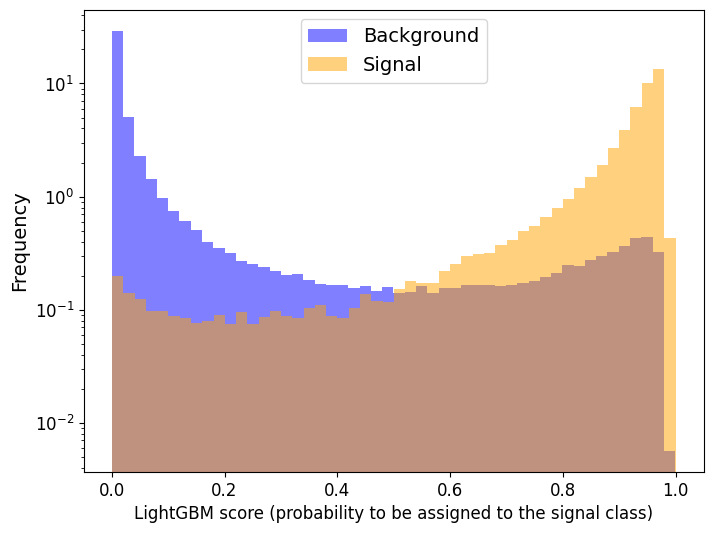

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(df_test_Addevtmu[(df_test_Addevtmu["truth_label"]==0 )]["signal_score"],
         weights = df_test_Addevtmu[(df_test_Addevtmu["truth_label"]==0 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5, 
         histtype = 'stepfilled', label='Background', color = 'b')

plt.hist(df_test_Addevtmu[(df_test_Addevtmu["truth_label"]==1 )]["signal_score"],
         weights = df_test_Addevtmu[(df_test_Addevtmu["truth_label"]==1 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5,
         histtype = 'stepfilled', label='Signal', color = 'orange')

plt.ylabel('Frequency', fontsize = 14)

plt.legend(loc='upper center', fontsize = 14)
plt.gca().set(xlabel="LightGBM score (probability to be assigned to the signal class)")

#plt.savefig(savedir+'AddEvtmu_score_lr_0.09_35_skim30.pdf')
plt.show()

### ROC curve

1) compute signal and background efficiencies for "official" cut-based Tight selection

In [31]:
s_tot = sum( df_test_Addevtmu[(df_test_Addevtmu["truth_label"] == 1)]["weight"] )
s_selected = sum( df_test_Addevtmu[(df_test_Addevtmu["truth_label"] == 1) & (df_test_Addevtmu['y_IsTight'].values)]["weight"] )
s_eff = s_selected / s_tot

b_tot = sum( df_test_Addevtmu[(df_test_Addevtmu["truth_label"] == 0)]["weight"] )
b_selected = sum( df_test_Addevtmu[(df_test_Addevtmu["truth_label"] == 0) & (df_test_Addevtmu['y_IsTight'].values)]["weight"] )
b_eff = b_selected / b_tot

In [32]:
print(f"Number of signal events                   = {s_tot:12.0f}")
print(f"Number of signal events passing Tight     = {s_selected:12.0f}")
print(f"Signal efficiency of cut-based Tight      = {100.*s_selected/s_tot:11.2f}%" )
print()
print(f"Number of background events               = {b_tot:12.0f}")
print(f"Number of background events passing Tight = {b_selected:12.0f}")
print(f"Background efficiency of cut-based Tight  = {100.*b_selected/b_tot:11.2f}%" )
print(f"Background rejection of cut-based Tight   = {100.*(1-b_selected/b_tot):11.2f}%" )

Number of signal events                   =    722080289
Number of signal events passing Tight     =    579900633
Signal efficiency of cut-based Tight      =       80.31%

Number of background events               =    721046049
Number of background events passing Tight =     45635422
Background efficiency of cut-based Tight  =        6.33%
Background rejection of cut-based Tight   =       93.67%


2) Plot ROC curve of trained BDT with weighted events, compare to current cut-based Tight selection 

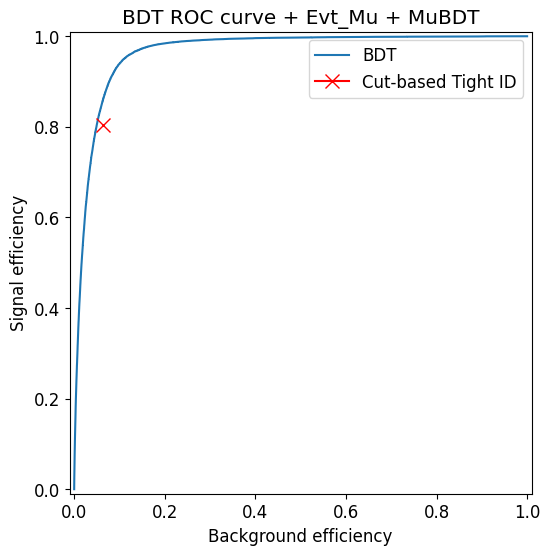

In [33]:
fig, ax = plt.subplots(figsize=(8,6))

mod_disp = RocCurveDisplay.from_estimator(model_skim30_Addevtmu, x_test, y_test, sample_weight=weight_test, 
                                          label="BDT", ax=ax) 

plt.plot(b_eff, s_eff, marker="x", markersize=10, color="red", label = 'Cut-based Tight ID')

plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')

#plt.xlim([0.0, 0.15])
#plt.ylim([0.65, 1.0])
#plt.title('BDT ROC curve - zoom')

plt.title('BDT ROC curve + Evt_Mu + MuBDT')
plt.legend()

#plt.savefig(savedir+'AddEvtmu_ROC_lr_0.05_35_weight_skim30.pdf')
plt.show()

### Correlation between input variables

In [34]:
#x_train_sel = x_train.query('y_wtots1 >- 800 & y_weta1 > -800')
#x_train_sel.reset_index(inplace=True, drop=True)

In [35]:
corr = x_train.corr()

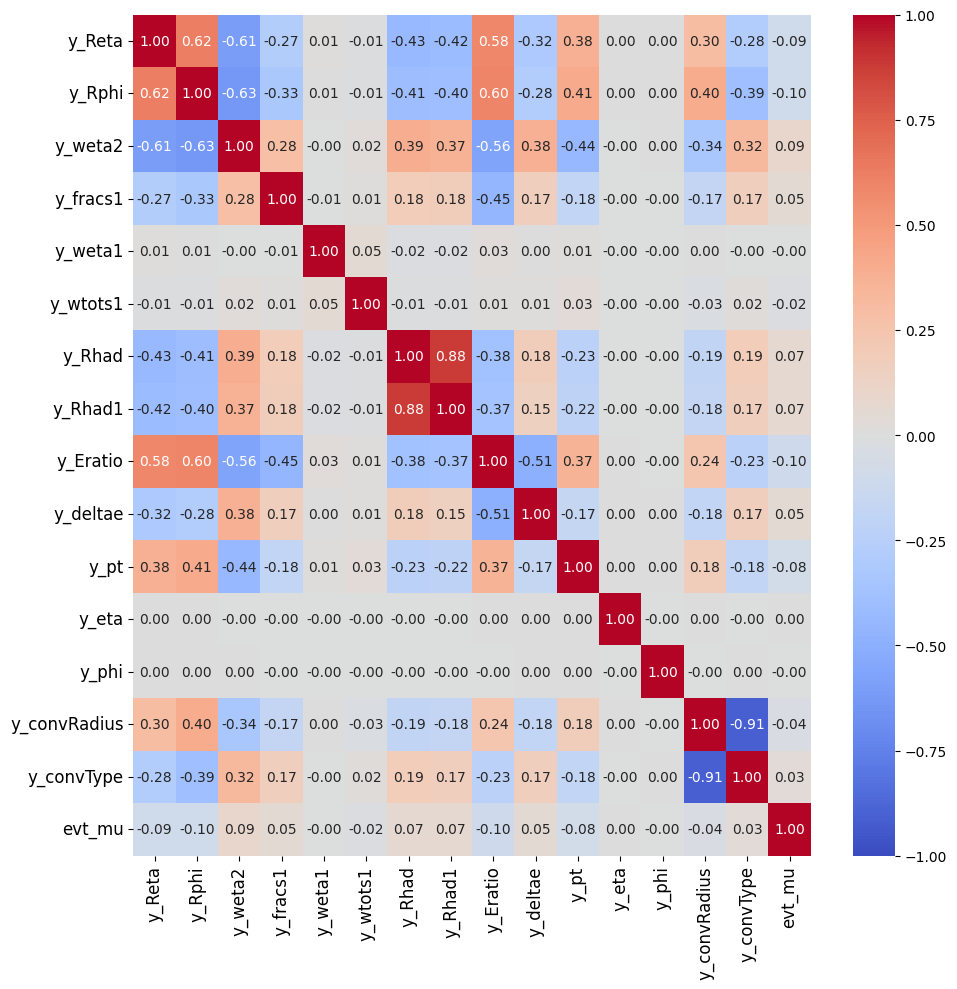

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
#plt.savefig(savedir+'AddEvtmu_correlations_train_sample_all_skim30.pdf')
plt.show()

In [37]:
#corr_sig = x_train[(y_train==1)].corr()
#corr_bkg = x_train[(y_train==0)].corr()